# Imports

In [1]:
from itertools import product
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings('ignore')

# Configs

In [3]:
INPUT_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/features_df_phase2.parquet'
OUTPUT_PATH = '/Users/maedeh/Desktop/data/Ridge_predictions_loc_phase2.parquet'


FEATURE_LIST = ['day_of_week',
                'day_of_month',

                'max_previous_week_interval',
                'max_previous_7exact_interval',
    
                'previous_day_9interval',
                'previous_day_10interval',
                'previous_day_14interval',
                'previous_day_15interval',
                'previous_day_17interval',

                'avrg_previous_2day_8interval',
                
                'diff_previous_2day_interval',
                'diff_previous_2day_previous_interval',
    
                'previous_day_interval',
                'previous_2day_interval',
                'previous_3day_interval',
                'previous_4day_interval',
                'previous_5day_interval',
                'previous_6day_interval',
                'previous_week_interval',
                'previous_8day_interval',
                'previous_9day_interval',
                'previous_10day_interval',
                'previous_11day_interval',
                'previous_12day_interval',
                'previous_13day_interval',
                'previous_2week_interval'
               ]


TEST_START_DATE = '2023-04-1'
VALIDATION_START_DATE = '2023-03-18'

NUM_INTERVAL_PER_DAY = 8
HIGH_DEMAND_NUMS = 40
SORT_METHOD = 'mean'

# Data preparation


## Load Data

In [4]:
features_df = pd.read_parquet(INPUT_PATH, engine='pyarrow')
print(f'rfeatures dataframe shape : {features_df.shape}')
features_df.head()

rfeatures dataframe shape : (251520, 7)


,Location,Date,Hour_interval,Demand,previous_day_interval,previous_week_interval,previous_2week_interval
0,1,2023-01-01,0,0.0,NaN,NaN,NaN
1,1,2023-01-01,3,1.0,NaN,NaN,NaN
2,1,2023-01-01,6,1.0,NaN,NaN,NaN
3,1,2023-01-01,9,1.0,NaN,NaN,NaN
4,1,2023-01-01,12,13.0,NaN,NaN,NaN


## Add feature

In [5]:
def add_feature(dataset, lag_num):
    
    for i in range(1,lag_num):
        if i not in(1,7):
            dataset[f'previous_{i}day_interval'] = dataset.groupby('Location')['Demand'].shift(i*NUM_INTERVAL_PER_DAY)

    
    dataset['day_of_week'] = dataset['Date'].dt.dayofweek
    dataset['day_of_month'] = dataset['Date'].dt.day
    dataset['time'] = dataset['Hour_interval']
    dataset['zone'] = dataset['Location']

    
    dataset['max_previous_week_interval'] = dataset.groupby('Location')['Demand'].rolling(window = 7*NUM_INTERVAL_PER_DAY).max().reset_index(drop=True)
    dataset['max_previous_2week_interval'] = dataset.groupby('Location')['Demand'].rolling(window = 14*NUM_INTERVAL_PER_DAY).max().reset_index(drop=True)

    
    df = dataset.sort_values(['Location','Hour_interval','Date'])[['Location','Hour_interval','Date','Demand']]
    df['max_previous_7exact_interval'] = dataset.groupby(['Location','Hour_interval'])['Demand'].rolling(window = 7).max().values
    dataset['max_previous_7exact_interval'] = df.sort_values(['Location', 'Date','Hour_interval'])['max_previous_7exact_interval']
    df['max_previous_14exact_interval'] = dataset.groupby(['Location','Hour_interval'])['Demand'].rolling(window = 14).max().values
    dataset['max_previous_14exact_interval'] = df.sort_values(['Location', 'Date','Hour_interval'])['max_previous_14exact_interval']

    
    dataset['previous_day_9interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+1)
    dataset['previous_day_10interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+2)
    dataset['previous_day_11interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+3)
    dataset['previous_day_12interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+4)
    dataset['previous_day_13interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+5)
    dataset['previous_day_14interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+6)
    dataset['previous_day_15interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+7)
    dataset['previous_day_17interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+9)

    
    dataset['avrg_previous_2day_8interval'] = (8*dataset['previous_day_9interval']+7*dataset['previous_day_10interval']+\
    6*dataset['previous_day_11interval']+5*dataset['previous_day_12interval']+4*dataset['previous_day_13interval']+\
    3*dataset['previous_day_14interval']+2*dataset['previous_day_15interval']+dataset['previous_2week_interval'])/NUM_INTERVAL_PER_DAY

    
    dataset['diff_previous_2day_previous_interval'] = dataset['previous_day_17interval']-dataset['previous_day_9interval']

    
    dataset['diff_previous_2day_interval'] = dataset['previous_day_interval']-dataset['previous_2day_interval']
    dataset['diff_previous_2week_interval'] = dataset['previous_week_interval']-dataset['previous_2week_interval']

    
    return dataset



In [6]:
new_features_df = add_feature(features_df, lag_num = 14)
print(f'new features dataframe shape : {new_features_df.shape}')
new_features_df.head()

new features dataframe shape : (251520, 38)


,Location,Date,Hour_interval,Demand,previous_day_interval,previous_week_interval,previous_2week_interval,previous_2day_interval,previous_3day_interval,previous_4day_interval,...,previous_day_11interval,previous_day_12interval,previous_day_13interval,previous_day_14interval,previous_day_15interval,previous_day_17interval,avrg_previous_2day_8interval,diff_previous_2day_previous_interval,diff_previous_2day_interval,diff_previous_2week_interval
0,1,2023-01-01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2023-01-01,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2023-01-01,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2023-01-01,9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2023-01-01,12,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def feature_selection(dataset, FEATURE_LIST):
    dataset = dataset[['Location','Date','Hour_interval','Demand']+FEATURE_LIST]
    dataset.dropna(inplace = True)
    return dataset

In [8]:
selected_features_df = feature_selection(new_features_df, FEATURE_LIST)
print(f'selected features dataframe shape : {selected_features_df.shape}')
selected_features_df.head()

selected features dataframe shape : (222176, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
112,1,2023-01-15,0,0.0,6,15,14.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
113,1,2023-01-15,3,2.0,6,15,14.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0
114,1,2023-01-15,6,1.0,6,15,14.0,2.0,0.0,0.0,...,0.0,2.0,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0
115,1,2023-01-15,9,0.0,6,15,14.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0
116,1,2023-01-15,12,8.0,6,15,14.0,8.0,1.0,1.0,...,1.0,1.0,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0


## Split Train and Test Data

In [9]:
def high_demand_split(dataset):
    high_index = dataset.groupby(['Location'])['Demand'].aggregate([SORT_METHOD]).sort_values(SORT_METHOD,ascending=False).reset_index()
    high_demand_df = dataset[dataset['Location'].isin(high_index['Location'][:HIGH_DEMAND_NUMS])]
    return high_demand_df

In [10]:
High_demand_df = high_demand_split(selected_features_df)
print(f'High_demand_selected_feature dataframe shape : {High_demand_df.shape}')
High_demand_df.head()

High_demand_selected_feature dataframe shape : (33920, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
40432,43,2023-01-15,0,27.0,6,15,652.0,27.0,132.0,341.0,...,10.0,3.0,23.0,28.0,11.0,6.0,5.0,1.0,4.0,204.0
40433,43,2023-01-15,3,2.0,6,15,652.0,10.0,17.0,132.0,...,3.0,3.0,8.0,5.0,6.0,3.0,2.0,5.0,3.0,23.0
40434,43,2023-01-15,6,39.0,6,15,652.0,158.0,8.0,17.0,...,131.0,102.0,48.0,51.0,105.0,134.0,112.0,120.0,31.0,28.0
40435,43,2023-01-15,9,182.0,6,15,652.0,267.0,38.0,8.0,...,244.0,224.0,181.0,209.0,257.0,248.0,255.0,233.0,142.0,101.0
40436,43,2023-01-15,12,478.0,6,15,652.0,503.0,206.0,38.0,...,404.0,361.0,446.0,480.0,473.0,541.0,376.0,421.0,450.0,306.0


In [11]:
def high_demand_split(dataset):
    high_index = dataset.groupby(['Location'])['Demand'].aggregate([SORT_METHOD]).sort_values(SORT_METHOD,ascending=False).reset_index()
    high_loc_df = dataset[dataset['Location'].isin(high_index['Location'][:HIGH_DEMAND_NUMS])]
    high_loc_hour_df = high_loc_df[~high_loc_df['Hour_interval'].isin([3,6])]
    high_loc_hour_df = high_loc_hour_df.groupby(['Location','Hour_interval']).agg(Min=('Demand','min')).sort_values(by='Min',ascending=False).reset_index()
    high_demand_df = dataset.merge(high_loc_hour_df[['Location','Hour_interval']], on=['Location','Hour_interval'])
    return high_demand_df

In [12]:
High_demand_df = high_demand_split(selected_features_df)
print(f'High_demand_selected_feature dataframe shape : {High_demand_df.shape}')
High_demand_df.head()

High_demand_selected_feature dataframe shape : (25440, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
0,43,2023-01-15,0,27.0,6,15,652.0,27.0,132.0,341.0,...,10.0,3.0,23.0,28.0,11.0,6.0,5.0,1.0,4.0,204.0
1,43,2023-01-16,0,12.0,0,16,652.0,27.0,115.0,399.0,...,8.0,10.0,3.0,23.0,28.0,11.0,6.0,5.0,1.0,4.0
2,43,2023-01-17,0,6.0,1,17,652.0,27.0,57.0,140.0,...,8.0,8.0,10.0,3.0,23.0,28.0,11.0,6.0,5.0,1.0
3,43,2023-01-18,0,6.0,2,18,652.0,27.0,49.0,119.0,...,21.0,8.0,8.0,10.0,3.0,23.0,28.0,11.0,6.0,5.0
4,43,2023-01-19,0,10.0,3,19,652.0,27.0,108.0,202.0,...,17.0,21.0,8.0,8.0,10.0,3.0,23.0,28.0,11.0,6.0


In [13]:
def train_test_splitting(dataset, START_DATE):

    train_df = dataset[dataset['Date'] < START_DATE]
    test_df = dataset[dataset['Date'] >= START_DATE]

    return train_df, test_df

In [14]:
train_df, test_df = train_test_splitting(High_demand_df, TEST_START_DATE)

In [15]:
print(f'train dataframe shape : {train_df.shape}')
train_df.tail()

train dataframe shape : (18240, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
25405,264,2023-03-27,21,106.0,0,27,239.0,204.0,185.0,172.0,...,204.0,165.0,110.0,142.0,190.0,160.0,175.0,184.0,146.0,92.0
25406,264,2023-03-28,21,137.0,1,28,239.0,204.0,225.0,204.0,...,155.0,204.0,165.0,110.0,142.0,190.0,160.0,175.0,184.0,146.0
25407,264,2023-03-29,21,177.0,2,29,243.0,177.0,181.0,146.0,...,172.0,155.0,204.0,165.0,110.0,142.0,190.0,160.0,175.0,184.0
25408,264,2023-03-30,21,201.0,3,30,261.0,201.0,243.0,192.0,...,170.0,172.0,155.0,204.0,165.0,110.0,142.0,190.0,160.0,175.0
25409,264,2023-03-31,21,193.0,4,31,276.0,201.0,261.0,201.0,...,118.0,170.0,172.0,155.0,204.0,165.0,110.0,142.0,190.0,160.0


In [16]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7200, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
76,43,2023-04-01,0,27.0,5,1,684.0,29.0,116.0,249.0,...,5.0,29.0,27.0,16.0,8.0,12.0,7.0,7.0,31.0,21.0
77,43,2023-04-02,0,27.0,6,2,654.0,27.0,149.0,358.0,...,6.0,5.0,29.0,27.0,16.0,8.0,12.0,7.0,7.0,31.0
78,43,2023-04-03,0,4.0,0,3,654.0,27.0,132.0,341.0,...,12.0,6.0,5.0,29.0,27.0,16.0,8.0,12.0,7.0,7.0
79,43,2023-04-04,0,12.0,1,4,654.0,27.0,51.0,188.0,...,19.0,12.0,6.0,5.0,29.0,27.0,16.0,8.0,12.0,7.0
80,43,2023-04-05,0,11.0,2,5,654.0,27.0,64.0,309.0,...,18.0,19.0,12.0,6.0,5.0,29.0,27.0,16.0,8.0,12.0


In [17]:
gridsearch_train_df, validation_df = train_test_splitting(train_df, VALIDATION_START_DATE)

In [18]:
print(f'gridsearch_train dataframe shape : {gridsearch_train_df.shape}')
gridsearch_train_df.head()

gridsearch_train dataframe shape : (14880, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
0,43,2023-01-15,0,27.0,6,15,652.0,27.0,132.0,341.0,...,10.0,3.0,23.0,28.0,11.0,6.0,5.0,1.0,4.0,204.0
1,43,2023-01-16,0,12.0,0,16,652.0,27.0,115.0,399.0,...,8.0,10.0,3.0,23.0,28.0,11.0,6.0,5.0,1.0,4.0
2,43,2023-01-17,0,6.0,1,17,652.0,27.0,57.0,140.0,...,8.0,8.0,10.0,3.0,23.0,28.0,11.0,6.0,5.0,1.0
3,43,2023-01-18,0,6.0,2,18,652.0,27.0,49.0,119.0,...,21.0,8.0,8.0,10.0,3.0,23.0,28.0,11.0,6.0,5.0
4,43,2023-01-19,0,10.0,3,19,652.0,27.0,108.0,202.0,...,17.0,21.0,8.0,8.0,10.0,3.0,23.0,28.0,11.0,6.0


In [19]:
print(f'validation dataframe shape : {validation_df.shape}')
validation_df.head()

validation dataframe shape : (3360, 30)


,Location,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,previous_day_10interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
62,43,2023-03-18,0,21.0,5,18,655.0,34.0,133.0,277.0,...,8.0,28.0,21.0,12.0,16.0,7.0,7.0,2.0,25.0,19.0
63,43,2023-03-19,0,31.0,6,19,655.0,34.0,123.0,332.0,...,7.0,8.0,28.0,21.0,12.0,16.0,7.0,7.0,2.0,25.0
64,43,2023-03-20,0,7.0,0,20,655.0,34.0,118.0,389.0,...,31.0,7.0,8.0,28.0,21.0,12.0,16.0,7.0,7.0,2.0
65,43,2023-03-21,0,7.0,1,21,655.0,34.0,36.0,124.0,...,16.0,31.0,7.0,8.0,28.0,21.0,12.0,16.0,7.0,7.0
66,43,2023-03-22,0,12.0,2,22,579.0,34.0,81.0,221.0,...,34.0,16.0,31.0,7.0,8.0,28.0,21.0,12.0,16.0,7.0


# Model Training

## **Ridge Regression**

### Model Tuning

In [20]:
def grid_search(test_parameters, train_data, validation_data, feature_list = FEATURE_LIST):
    best_score = float('inf')
    best_params = None
    param_combination = product(*test_parameters.values())
    for param in param_combination:
        param_dict = dict(zip(test_parameters.keys(), param))
        model = Ridge(**param_dict)
        model.fit(train_data[feature_list], train_data['Demand'])
        validation_predict_df = model.predict(validation_data[feature_list])
        score = mean_squared_error(validation_data['Demand'], validation_predict_df)
        if score<best_score:
            best_score = score
            best_params = param_dict
    return best_params, best_score

In [21]:
model = Ridge()
best_params, best_score = grid_search(
    {'alpha':[80000,100000,500000]},
    gridsearch_train_df, 
    validation_df, 
    feature_list = FEATURE_LIST
    )

print(best_params, best_score)

{'alpha': 100000} 3585.892128385498


### Prediction

In [22]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])


    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [23]:
model = Ridge(**best_params)
train_prediction_df , test_prediction_df  = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [24]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):


    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby(['Date','Hour_interval'])['Demand'].sum()
    test_data = test_data.groupby(['Date','Hour_interval'])['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby(['Date','Hour_interval'])['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby(['Date','Hour_interval'])['Predicted'].sum()

    plt.figure(figsize=(30,10))
    plt.title('Train', fontsize = 30)
    plt.plot(range(1,len(train_data)+1), train_data)
    plt.plot(range(1,len(train_data)+1), predicted_train_df)
    plt.xlabel('time interval', fontsize = 15)
    plt.legend(["Real Value", "Predicted"], loc ="lower right", fontsize = 15)
    plt.show()

    plt.figure(figsize=(30,10))
    plt.title('Test', fontsize = 30)
    plt.plot(range(1,len(test_data)+1), test_data)
    plt.plot(range(1,len(test_data)+1), predicted_test_df)
    plt.xlabel('time interval', fontsize = 15)
    plt.legend(["Real Value", "Predicted"], loc ="lower right", fontsize = 15)
    plt.show()

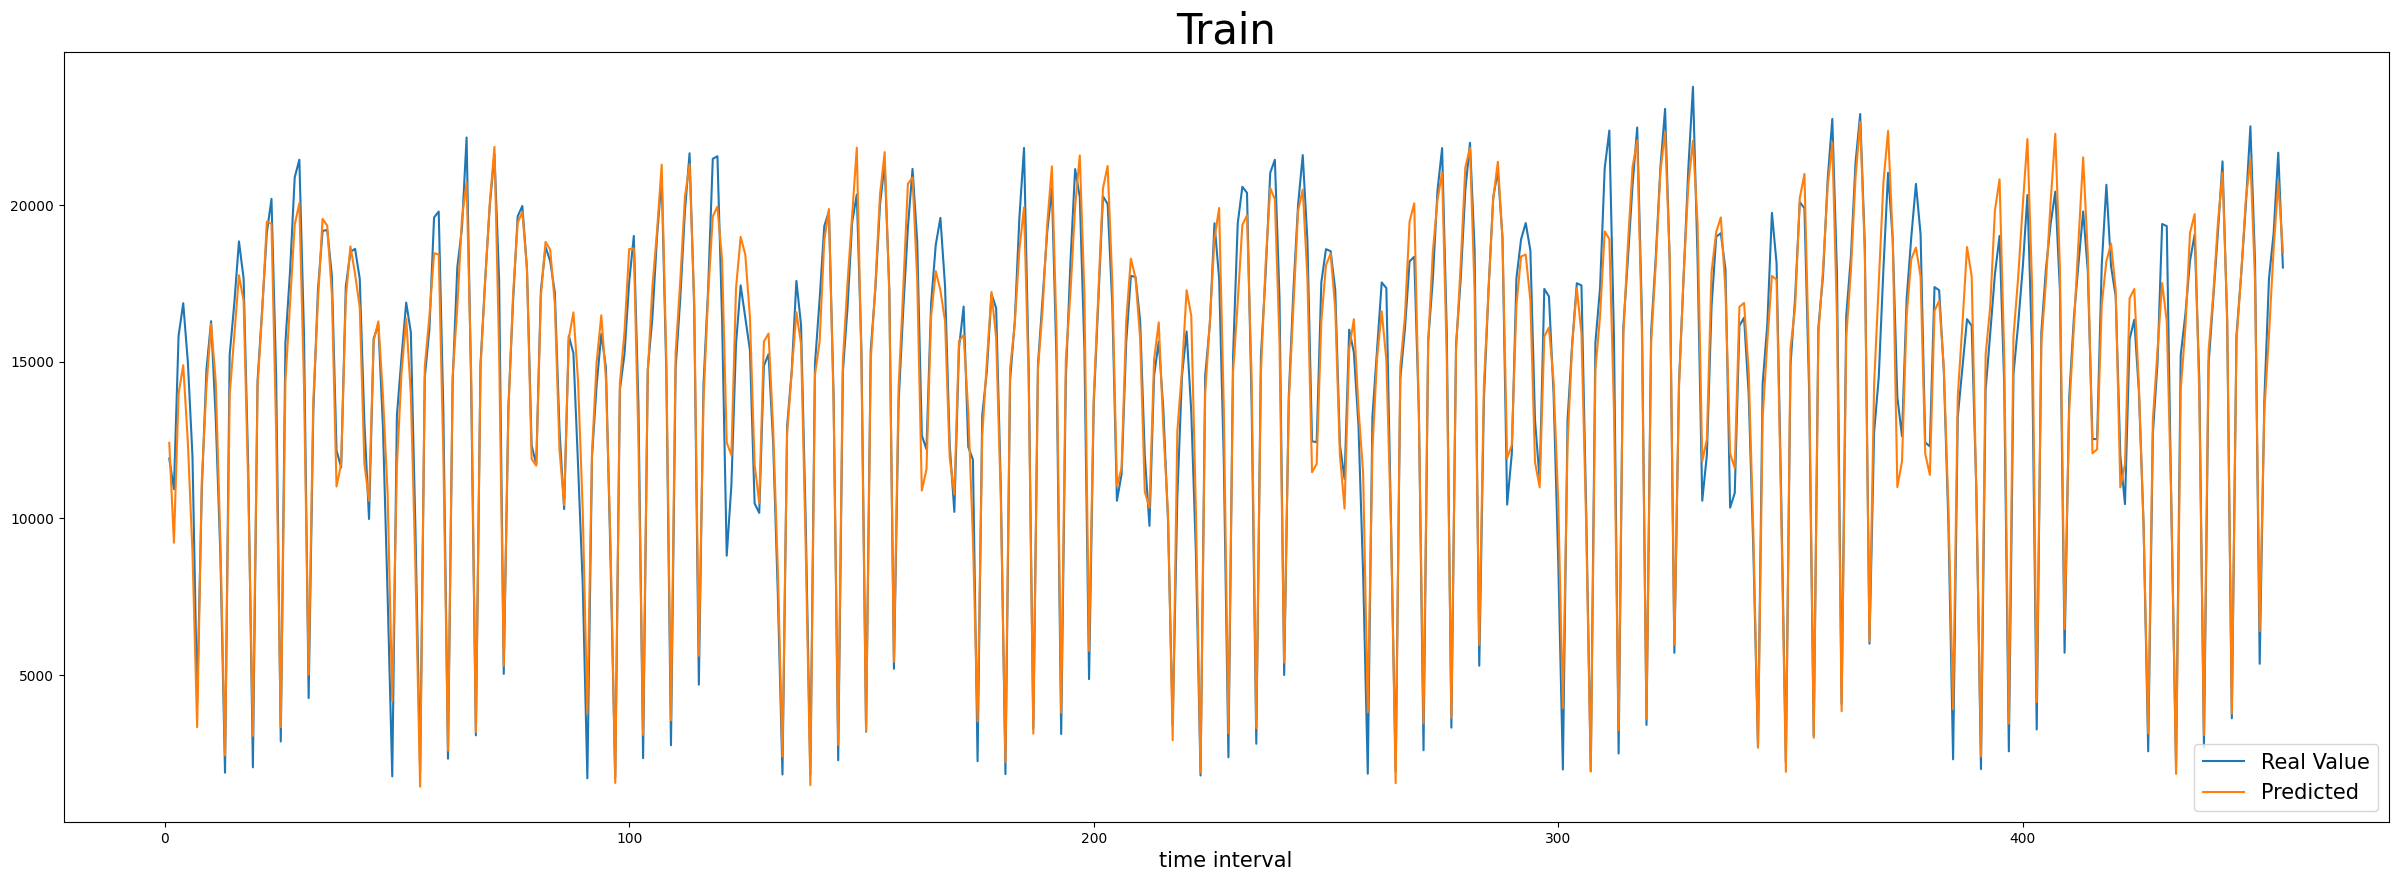

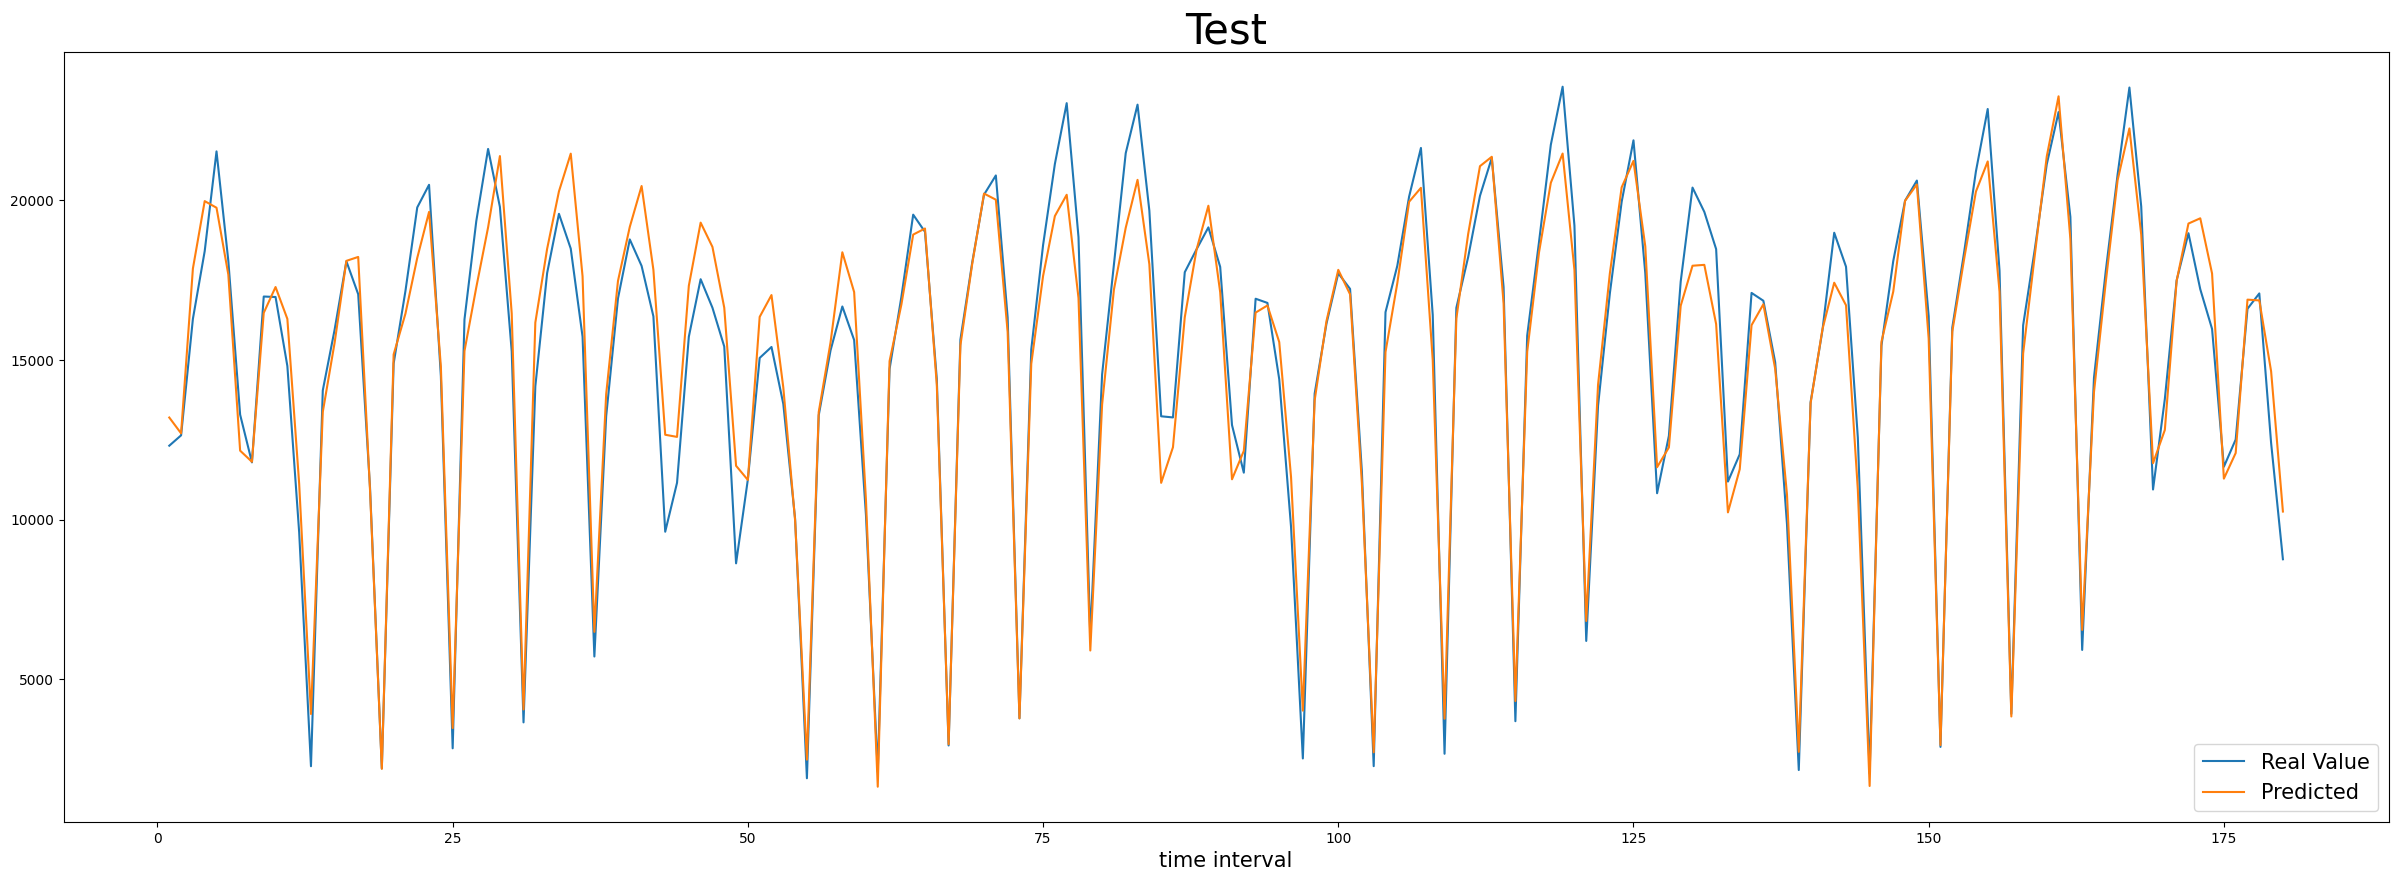

In [25]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [26]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [27]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_data['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_data['Demand'], test_prediction_df)


In [28]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 38.4712905286773
MSE : 3522.2379756601154
MAPE : 0.16282913468606136
Ridge Regression test scores:
MAE : 40.05024324669357
MSE : 3466.1659212660416
MAPE : 0.15304865808551463


# File Saving

In [29]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [30]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date','Hour_interval']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [31]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)

In [32]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (7200, 4)


,Location,Date,Hour_interval,Predicted_demand
0,43,2023-04-01,0,29.183025
1,43,2023-04-02,0,30.713272
2,43,2023-04-03,0,10.840377
3,43,2023-04-04,0,8.800745
4,43,2023-04-05,0,14.885329


In [33]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)